# **Modelo de interacción metabólica entre una reconstrucción metabólica de un esferoide de MCF-7 en co-cultivo con *Fusobacterium nucleatum***

## **1. Datos**

In [1]:
import micom
import pandas as pd
import numpy as np
import osqp
import pickle
import cobra
import cobra.io
import matplotlib.pyplot as plt
import logging
from pathlib import Path
from micom import load_pickle
from micom.media import minimal_medium
from micom.workflows import workflow
from micom import Community
from time import time
from cobra.flux_analysis import (single_gene_deletion, single_reaction_deletion)
from cobra.io import load_json_model, save_json_model, load_matlab_model, save_matlab_model, read_sbml_model, write_sbml_model

Importamos los paquetes requeridos así como micom: 

In [2]:
print("MICOM_version:", micom.__version__) #comprobar la version de micom

MICOM_version: 0.37.1


### **1.1. Reconstrucciones de MCF-7 y *Fusobacterium***

La reconstrucciónes de MCF-7 se obtuvieron del trabajo de **Modeling Cancer Metabolism Heterogeneity with MICOM** de Arellano y Resendis (github [aqui](https://github.com/resendislab/Modeling_Heterogeneity_Cancer_Metabolism_MICOM/tree/main)). En este trabajo, se identificaron 3 subpoblaciones de células en un esferoide de MCF-7:
* Modelo A - Invasive Population - I
* Modelo B - Reservoir Population - R
* Modelo C- Proliferating Population - P

In [3]:
A = cobra.io.read_sbml_model('modelos_mcf7_mod/A_normalizado.xml')
B = cobra.io.read_sbml_model('modelos_mcf7_mod/B_normalizado.xml')
C = cobra.io.read_sbml_model('modelos_mcf7_mod/C_normalizado.xml')

In [40]:
F = cobra.io.read_sbml_model('Fusobacterium.xml')

### **1.2. Gradiente de Oxigeno**

Simulamos la disposición de oxigeno para el gradiente de Oxigeno (EX_o2) en todas las reconstrucciones, simularemos que las bacterias están inmersas en las 3 capas del esferoide.

**Condiciones y abundancias relativas:**

**Cancer 51%**
* Subpoblación_A (C_A: 4.98%) - EX_ox: 0.007 - Hipoxia
* Subpoblación_B (C_B: 19.94%) - EX_ox: 0.115 - Intermedio 
* Subpoblación_C (C_C: 26.07%) - EX_ox: 0.16 - Normoxia

**Fusubacterium 49%**
* Fucubacterium_A (F_A: 16% ) - EX_ox: 0.007 - Hipoxia
* Fucubacterium_B (F_B: 16% ) - EX_ox: 0.115 - Intermedio
* Fucubacterium_C (F_C: 16% ) - EX_ox: 0.16 - Normoxia

In [9]:
#ajustar los bounds de O2 de las reconstrucciones: CANCER
A2 = A.copy()
A2.reactions.EX_o2_e.lower_bound = -0.007
write_sbml_model(A2, "A2.xml")

B2 = B.copy()
B2.reactions.EX_o2_e.lower_bound = -0.115
write_sbml_model(B2, "B2.xml")

C2 = C.copy()
C2.reactions.EX_o2_e.lower_bound = -0.16
write_sbml_model(C2, "C2.xml")

In [41]:
#ajustar los bounds de O2 de las reconstrucciones: FUSOBACTERIUM
## Adaptar los IDs de la reconstruccion
import re
F2 = F.copy()

def clean_id(old_id):
    # Reemplaza paréntesis por guion bajo
    new_id = re.sub(r"[()]", "_", old_id)
    # Elimina guiones bajos duplicados y finales
    new_id = re.sub(r"__+", "_", new_id).rstrip("_")
    return new_id

for rxn in F2.reactions:
    rxn.id = clean_id(rxn.id)

for met in F2.metabolites:
    met.id = clean_id(met.id)

for gene in F2.genes:
    gene.id = clean_id(gene.id)

cobra.io.write_sbml_model(F2, "F2.xml")

print(" Modelo F2 guardado con IDs sin paréntesis (F2.xml)")

 Modelo F2 guardado con IDs sin paréntesis (F2.xml)


In [42]:
F2 = cobra.io.read_sbml_model('F2.xml')
FA = F2.copy()
FA.reactions.EX_o2_e.lower_bound = -0.007
write_sbml_model(FA, "FA.xml")

FB = F2.copy()
FB.reactions.EX_o2_e.lower_bound = -0.115
write_sbml_model(FB, "FB.xml")

FC = F2.copy()
FC.reactions.EX_o2_e.lower_bound = -0.16
write_sbml_model(FC, "FC.xml")

## **2. Creación de la comunidad**

In [43]:
TyF = TyF = {'id': ['CanA', 'CanB', 'CanC','FusoA','FusoB','FusoC'],
    'file': ["A2.xml", 'B2.xml','C2.xml',"FA.xml","FB.xml","FC.xml"],
     'abundance': [0.04885,0.1955,0.2265,0.16665,0.16665,0.16665]
    }

df_TyF = pd.DataFrame(data=TyF)
df_TyF

,id,file,abundance
0,CanA,A2.xml,0.04885
1,CanB,B2.xml,0.19550
2,CanC,C2.xml,0.22650
3,FusoA,FA.xml,0.16665
4,FusoB,FB.xml,0.16665
5,FusoC,FC.xml,0.16665


In [44]:
TyF = micom.Community (df_TyF, solver = "osqp")
print("build a community with a total of {} reactions.".format(len(TyF.reactions)))

Output()

build a community with a total of 6178 reactions.


### **2.2. Nuevo medio**

Se modificara el medio de crecimiento de la comunidad por un medio compuesto por: el medio minimo + McCoys 5A

In [45]:
TyF.medium

{'EX_ac_m': 1000.0,
 'EX_acac_m': 1000.0,
 'EX_ala_L_m': 1000.0,
 'EX_arg_L_m': 1000.0,
 'EX_asn_L_m': 1000.0,
 'EX_asp_L_m': 1000.0,
 'EX_ca2_m': 1000.0,
 'EX_chol_m': 0.16,
 'EX_cl_m': 1000.0,
 'EX_co2_m': 1000.0,
 'EX_cys_L_m': 1000.0,
 'EX_fol_m': 0.16,
 'EX_gal_m': 1000.0,
 'EX_gln_L_m': 1000.0,
 'EX_glu_L_m': 1000.0,
 'EX_gly_m': 1000.0,
 'EX_h2o_m': 1000.0,
 'EX_h_m': 1000.0,
 'EX_his_L_m': 1000.0,
 'EX_ile_L_m': 1000.0,
 'EX_inost_m': 0.16,
 'EX_lac_D_m': 1000.0,
 'EX_leu_L_m': 1000.0,
 'EX_lys_L_m': 1000.0,
 'EX_met_L_m': 1000.0,
 'EX_na1_m': 1000.0,
 'EX_nac_m': 1000.0,
 'EX_ncam_m': 0.16,
 'EX_nh4_m': 1000.0,
 'EX_o2_m': 0.16,
 'EX_phe_L_m': 1000.0,
 'EX_pi_m': 1000.0,
 'EX_pnto_R_m': 1000.0,
 'EX_pro_L_m': 1000.0,
 'EX_pydxn_m': 0.16,
 'EX_pyr_m': 1000.0,
 'EX_ribflv_m': 0.16,
 'EX_ser_L_m': 1000.0,
 'EX_so4_m': 1000.0,
 'EX_succ_m': 1000.0,
 'EX_thmmp_m': 0.16,
 'EX_thr_L_m': 1000.0,
 'EX_trp_L_m': 1000.0,
 'EX_tyr_L_m': 1000.0,
 'EX_urea_m': 1000.0,
 'EX_uri_m': 1000.0,
 

In [46]:
sol = TyF.cooperative_tradeoff()
rates = sol.members.growth_rate.drop("medium")  # extracellular medium has no growth rate

In [47]:
med1 = minimal_medium(TyF, 0.8, minimize_components=True)
med1

[11/24/25 12:56:43] WARNING  the MIP version of minimal media is extremely slow for models that large   ]8;id=365726;file:///home/gaby_torres/miniconda3/lib/python3.12/site-packages/micom/media.py\media.py]8;;\:]8;id=64373;file:///home/gaby_torres/miniconda3/lib/python3.12/site-packages/micom/media.py#72\72]8;;\
                             :(                                                                                    

EX_arg_L_m      0.233360
EX_ca2_m        0.005946
EX_chol_m       0.006646
EX_cl_m         0.005946
EX_cys_L_m      0.081436
EX_gal_m        0.010637
EX_ile_L_m      0.226176
EX_inost_m      0.006844
EX_lys_L_m      0.276834
EX_met_L_m      0.005915
EX_nac_m        0.011891
EX_o2_m         0.160000
EX_phe_L_m      0.016952
EX_pi_m         0.939285
EX_pnto_R_m     0.011891
EX_so4_m        0.005946
EX_trp_L_m      0.042508
EX_tyr_L_m      0.108383
EX_uri_m        0.003663
EX_val_L_m      0.327000
EX_acgam_m      6.483943
EX_ade_m        0.168177
EX_alahis_m     0.075404
EX_alathr_m     0.199873
EX_cobalt2_m    0.005946
EX_cu2_m        0.005946
EX_cytd_m       0.116771
EX_fe2_m        0.005946
EX_fe3_m        0.005946
EX_fru_m        4.781373
EX_glyleu_m     0.355059
EX_glyphe_m     0.130546
EX_gua_m        0.180033
EX_k_m          0.005946
EX_metala_m     0.119645
EX_mg2_m        0.005946
EX_mn2_m        0.005946
EX_ura_m        0.106794
EX_zn2_m        0.005946
dtype: float64

In [48]:
med = minimal_medium(TyF, 0.95*sol.growth_rate, min_growth=0.95*rates)
med

EX_arg_L_m       5.763859
EX_asn_L_m      26.601750
EX_asp_L_m      51.498764
EX_ca2_m         0.153816
EX_chol_m        0.041161
EX_cl_m          0.153816
EX_cys_L_m       2.071360
EX_gal_m         0.065876
EX_gln_L_m       5.344914
EX_glu_L_m      58.452711
EX_h2o_m        21.547256
EX_his_L_m       2.085965
EX_ile_L_m       5.633678
EX_inost_m       0.087991
EX_lac_D_m      51.437408
EX_lys_L_m       6.711449
EX_met_L_m       0.036630
EX_nac_m         0.307633
EX_o2_m          0.160000
EX_phe_L_m       3.618480
EX_pi_m         23.355289
EX_pnto_R_m      0.307633
EX_pro_L_m       3.110199
EX_pyr_m        56.808898
EX_ser_L_m      54.625945
EX_so4_m         0.153816
EX_succ_m       46.648640
EX_thr_L_m      51.573616
EX_trp_L_m      51.501949
EX_tyr_L_m       2.682453
EX_uri_m         0.010981
EX_val_L_m       8.232503
EX_2obut_m      51.498764
EX_acald_m      51.498764
EX_acgam_m      51.498764
EX_ade_m         4.350799
EX_alathr_m      8.087933
EX_btoh_m       51.498764
EX_cit_m    

In [50]:
TyF.medium =  {
'EX_ala_L_m':30,
'EX_arg_L_m':30,  #### <--- BAC (importantes para la bacteria en medio minimo)
'EX_asn_L_m':30,
'EX_asp_L_m':30,
'EX_ca2_m':30, #### <--- BAC
'EX_chol_m':30,
'EX_cl_m':30, #### <--- BAC
'EX_cobalt2_m':0.06, ################# <--- BAC2 (importantes para la bacteria en medio minimo pero McCoy no lo tiene)
'EX_cu2_m':0.06,  #################### <--- BAC2
'EX_cys_L_m':30,
'EX_fe2_m':0.06, ##################### <--- BAC2
'EX_fe3_m':0.06, ##################### <--- BAC2
'EX_gal_m':30,  ## <- Carbon Souce of MCF-7 (esferoide)
'EX_gln_L_m':30,
'EX_his_L_m':30,
'EX_ile_L_m':30,
'EX_inost_m':30,
'EX_k_m':30,  #### <--- BAC
'EX_leu_L_m':30,
'EX_lys_L_m':30,  #### <--- BAC
'EX_met_L_m':30,
'EX_mg2_m':30,  #### <--- BAC
'EX_mn2_m':0.06,   ##################### <--- BAC2
'EX_nac_m':30,   #### <--- BAC
'EX_o2_m':30,
'EX_h2o_m':30,
'EX_phe_L_m':30, #### <--- BAC
'EX_pi_m':30, #### <--- BAC
'EX_pnto_R_m':30, #### <--- BAC
'EX_pro_L_m':30, #### <--- BAC
'EX_ser_L_m':30,
'EX_so4_m':30, #### <--- BAC
'EX_thr_L_m':30,
'EX_trp_L_m':30, #### <--- BAC
'EX_tyr_L_m':30, #### <--- BAC
'EX_val_L_m':30, #### <--- BAC
'EX_zn2_m':0.06, ########################<--- BAC2
'EX_adocbl_m':30,
'EX_anth_m':30,
'EX_ascb_L_m':30,
'EX_btn_m':30,
'EX_fol_m':30,
'EX_glc_D_m':30,
'EX_glu_L_m':30,
'EX_gly_m':30,
'EX_gthrd_m':30,
'EX_na1_m':30,
'EX_ncam_m':30,
'EX_pydxn_m':30,
'EX_ribflv_m':30,
'EX_thm_m':30
}

### **2.2. Optimización**

In [51]:
sol_TyF = TyF.cooperative_tradeoff(fraction = 0.8, fluxes =True, pfba = True)
sol_TyF

,abundance,growth_rate,reactions,metabolites
compartments,,,,
CanA,0.050319,0.995809,1126,982
CanB,0.201380,3.985269,742,616
CanC,0.233313,4.617199,1032,807
FusoA,0.171663,3.396544,1029,935
FusoB,0.171663,3.395110,1029,935
FusoC,0.171663,3.397043,1029,935
medium,NaN,NaN,191,191


#### **2.2.1. Tiempos de duplicación**

In [52]:
fluxes = sol_TyF.fluxes
flux_cancer_A_biomass = fluxes.loc['CanA', "biomass_reaction"]
flux_cancer_B_biomass = fluxes.loc['CanB', "biomass_reaction"]
flux_cancer_C_biomass = fluxes.loc['CanC', "biomass_reaction"]
flux_fuso_biomassA = fluxes.loc["FusoA", "EX_biomass_e"]
flux_fuso_biomassB = fluxes.loc["FusoB", "EX_biomass_e"]
flux_fuso_biomassC = fluxes.loc["FusoC", "EX_biomass_e"]

In [53]:
print("Growth Rate of the community:", sol_TyF.growth_rate, "mmol/gDW*hr")
print("Growth Rate of the A:", flux_cancer_A_biomass, "mmol/gDW*hr")
print("Growth Rate of the B:", flux_cancer_B_biomass, "mmol/gDW*hr")
print("Growth Rate of the C:", flux_cancer_C_biomass, "mmol/gDW*hr")
print("Growth Rate of the fusobacteriumA:", flux_fuso_biomassA, "mmol/gDW*hr")
print("Growth Rate of the fusobacteriumB:", flux_fuso_biomassB, "mmol/gDW*hr")
print("Growth Rate of the fusobacteriumC:", flux_fuso_biomassC, "mmol/gDW*hr")

Growth Rate of the community: 3.6789318360620564 mmol/gDW*hr
Growth Rate of the A: 0.9958093110323947 mmol/gDW*hr
Growth Rate of the B: 3.9852686222211084 mmol/gDW*hr
Growth Rate of the C: 4.617198705235454 mmol/gDW*hr
Growth Rate of the fusobacteriumA: 3.3965435110011373 mmol/gDW*hr
Growth Rate of the fusobacteriumB: 3.3951101160774595 mmol/gDW*hr
Growth Rate of the fusobacteriumC: 3.3970425578902272 mmol/gDW*hr


In [55]:
import math
r = math.log(2)

print("Community Cancer y Fusobacterium:")
print("doubling speed - Community:", r/sol_TyF.growth_rate, "hrs")
print("doubling speed - Cancer A:", r/ flux_cancer_A_biomass, "hrs")
print("doubling speed - Cancer B:", r/ flux_cancer_B_biomass, "hrs")
print("doubling speed - Cancer C:", r/ flux_cancer_C_biomass, "hrs")
print("doubling speed - FusobacteriumA:", r/ flux_fuso_biomassA, "hrs")
print("doubling speed - FusobacteriumB:", r/ flux_fuso_biomassB, "hrs")
print("doubling speed - FusobacteriumC:", r/ flux_fuso_biomassC, "hrs")

Community Cancer y Fusobacterium:
doubling speed - Community: 0.18840990033180197 hrs
doubling speed - Cancer A: 0.6960641689936925 hrs
doubling speed - Cancer B: 0.17392734248705016 hrs
doubling speed - Cancer C: 0.1501228829017005 hrs
doubling speed - FusobacteriumA: 0.20407428266851171 hrs
doubling speed - FusobacteriumB: 0.2041604415943872 hrs
doubling speed - FusobacteriumC: 0.2040443028745664 hrs


In [56]:
cancer = (flux_cancer_A_biomass+flux_cancer_B_biomass+flux_cancer_C_biomass)*0.50
fus = (flux_fuso_biomassA+flux_fuso_biomassB+flux_fuso_biomassC)*0.50

In [57]:
print("Cancer:", cancer)
print("Fusobacterium:", fus)

Cancer: 4.799138319244479
Fusobacterium: 5.094348092484412


In [58]:
print("doubling speed - Cancer:", r/cancer, "hrs")
print("doubling speed - fus :", r/fus, "hrs")

doubling speed - Cancer: 0.14443159051707982 hrs
doubling speed - fus : 0.1360619981156237 hrs


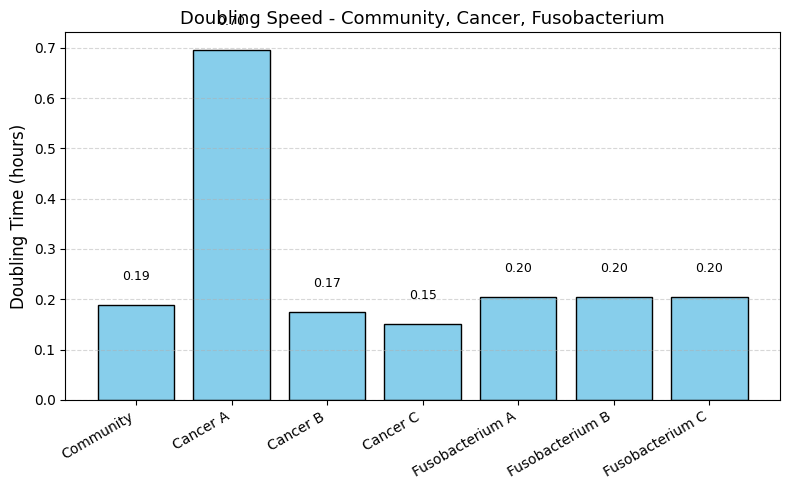

In [59]:
import matplotlib.pyplot as plt


# Calcula las velocidades de duplicación (en horas)
doubling_times = {
    "Community": r / sol_TyF.growth_rate,
    "Cancer A": r / flux_cancer_A_biomass,
    "Cancer B": r / flux_cancer_B_biomass,
    "Cancer C": r / flux_cancer_C_biomass,
    "Fusobacterium A": r / flux_fuso_biomassA,
    "Fusobacterium B": r / flux_fuso_biomassB,
    "Fusobacterium C": r / flux_fuso_biomassC
}

# Extrae nombres y valores
labels = list(doubling_times.keys())
values = list(doubling_times.values())

# Crear la gráfica
plt.figure(figsize=(8,5))
plt.bar(labels, values, color="skyblue", edgecolor="black")

# Estética
plt.ylabel("Doubling Time (hours)", fontsize=12)
plt.title("Doubling Speed - Community, Cancer, Fusobacterium", fontsize=13)
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Mostrar valores encima de las barras
for i, v in enumerate(values):
    plt.text(i, v + 0.05, f"{v:.2f}", ha='center', fontsize=9)

plt.tight_layout()
plt.show()

## **3. Visualización de flujos**

### **3.1. Medio**

In [60]:
medium_exchanges = fluxes.loc["medium", fluxes.columns.str.startswith("EX_")].to_frame().T
medium_exchanges

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


reaction,EX_15dap_e,EX_15dap_m,EX_2hb[e],EX_2hb_e,EX_2hb_m,EX_2mcit[e],EX_2mcit_e,EX_2mcit_m,EX_2obut_e,EX_2obut_m,...,EX_xmp_e,EX_xmp_m,EX_xoltri25[e],EX_xoltri25_e,EX_xoltri25_m,EX_xylt[e],EX_xylt_e,EX_xylt_m,EX_zn2_e,EX_zn2_m
medium,NaN,-0.0,NaN,NaN,-0.0,NaN,NaN,-0.0,NaN,0.0,...,NaN,0.0,NaN,NaN,-0.0,NaN,NaN,0.0,NaN,-0.013659


In [61]:
medium_exchanges_vertical = medium_exchanges.T.reset_index()
medium_exchanges_vertical.columns = ["reaction", "flux"]

In [62]:
medium_exchanges_vertical = medium_exchanges.T.reset_index()
medium_exchanges_vertical.columns = ["reaction", "flux"]

In [63]:
medium_exchanges_nonzero = medium_exchanges_vertical[medium_exchanges_vertical["flux"] != 0] #borramos los valores de reacción igual a 0

In [64]:
# Flujos positivos y negativos
top_positive = medium_exchanges_nonzero[medium_exchanges_nonzero["flux"] > 0].nlargest(10, "flux")
top_negative = medium_exchanges_nonzero[medium_exchanges_nonzero["flux"] < 0].nsmallest(10, "flux")

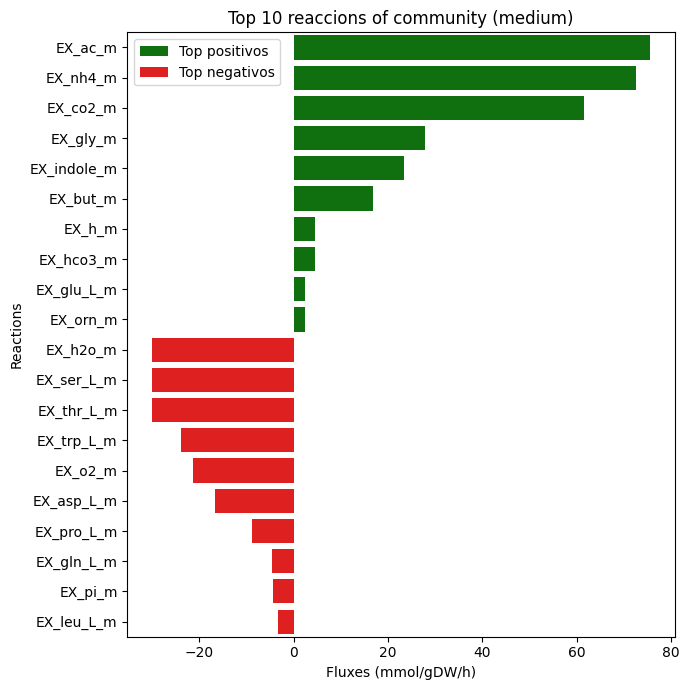

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(7,7))
# Pos
sns.barplot(x="flux", y="reaction", data=top_positive, color="green", label="Top positivos")
# Neg
sns.barplot(x="flux", y="reaction", data=top_negative, color="red", label="Top negativos")

plt.xlabel("Fluxes (mmol/gDW/h)")
plt.ylabel("Reactions")
plt.title("Top 10 reaccions of community (medium)")
plt.legend()
plt.tight_layout()
plt.show()

### **3.2. Cáncer - MCF-7**

#### **3.2.1. Subpoblación A (Invasiva)**

In [68]:
cancer_A_exchanges = sol_TyF.fluxes.loc["CanA", sol_TyF.fluxes.columns.str.startswith("EX_")]

In [71]:
cancer_A_exchanges_vertical = cancer_A_exchanges.reset_index()
cancer_A_exchanges_vertical.columns = ["reaction", "flux"]
cancer_A_exchanges_vertical["flux"] = cancer_A_exchanges_vertical["flux"].fillna(0) #NaN 0

In [74]:
cancer_A_exchanges_nonzero = cancer_A_exchanges_vertical[cancer_A_exchanges_vertical["flux"] != 0] #borramos los valores de reacción igual a 0

In [75]:
# Flujos positivos y negativos
top_positive = cancer_A_exchanges_nonzero[cancer_A_exchanges_nonzero["flux"] > 0].nlargest(30, "flux")
top_negative = cancer_A_exchanges_nonzero[cancer_A_exchanges_nonzero["flux"] < 0].nsmallest(30, "flux")

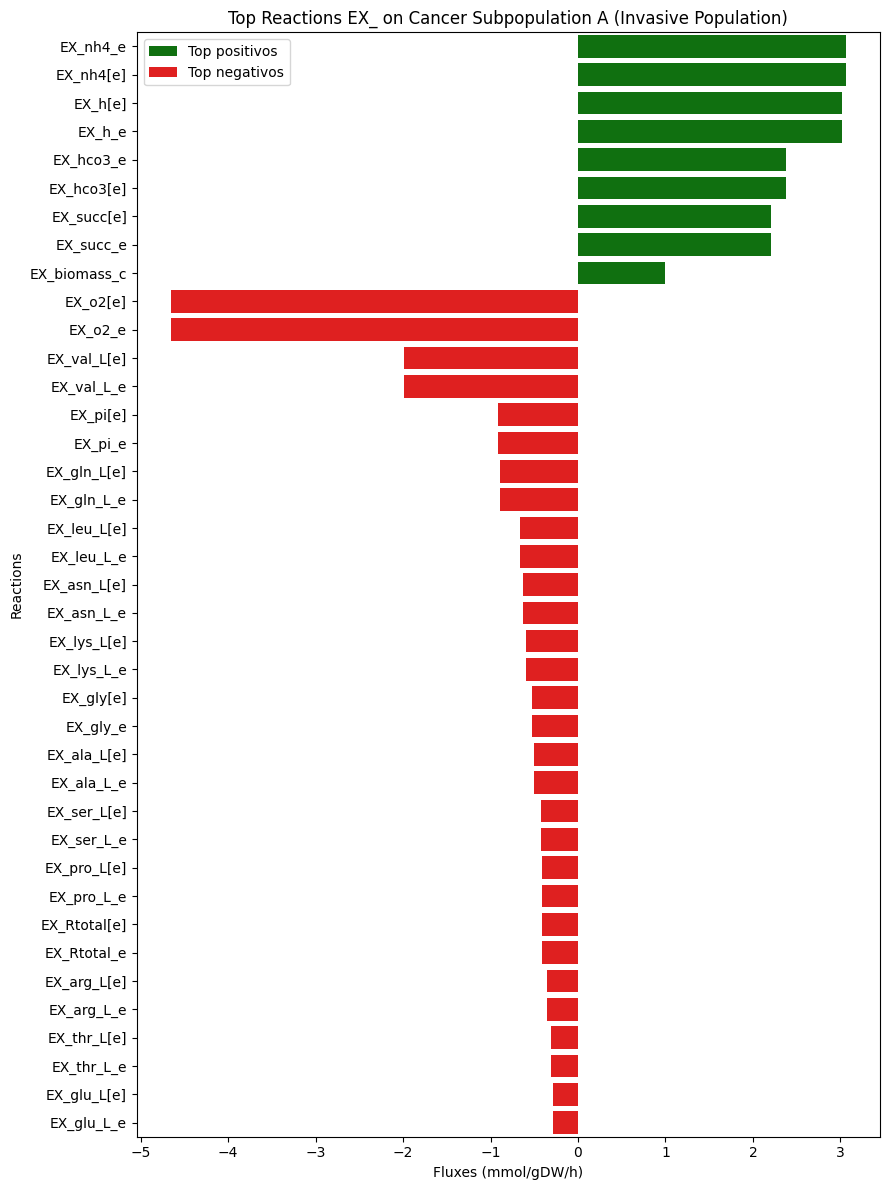

In [76]:
plt.figure(figsize=(9,12))

sns.barplot(x="flux", y="reaction", data=top_positive, color="green", label="Top positivos")

sns.barplot(x="flux", y="reaction", data=top_negative, color="red", label="Top negativos")

plt.xlabel("Fluxes (mmol/gDW/h)")
plt.ylabel("Reactions")
plt.title("Top Reactions EX_ on Cancer Subpopulation A (Invasive Population)")
plt.legend()
plt.tight_layout()
plt.show()

#### **3.2.2. Subpoblación B (Reservorio)** 

In [77]:
cancer_B_exchanges = sol_TyF.fluxes.loc["CanB", sol_TyF.fluxes.columns.str.startswith("EX_")]
cancer_B_exchanges_vertical = cancer_B_exchanges.reset_index()
cancer_B_exchanges_vertical.columns = ["reaction", "flux"]
cancer_B_exchanges_vertical["flux"] = cancer_B_exchanges_vertical["flux"].fillna(0) #NaN 0
cancer_B_exchanges_nonzero = cancer_B_exchanges_vertical[cancer_B_exchanges_vertical["flux"] != 0] #borramos los valores de reacción igual a 0

In [78]:
# Flujos positivos y negativos
top_positive = cancer_B_exchanges_nonzero[cancer_B_exchanges_nonzero["flux"] > 0].nlargest(30, "flux")
top_negative = cancer_B_exchanges_nonzero[cancer_B_exchanges_nonzero["flux"] < 0].nsmallest(30, "flux")

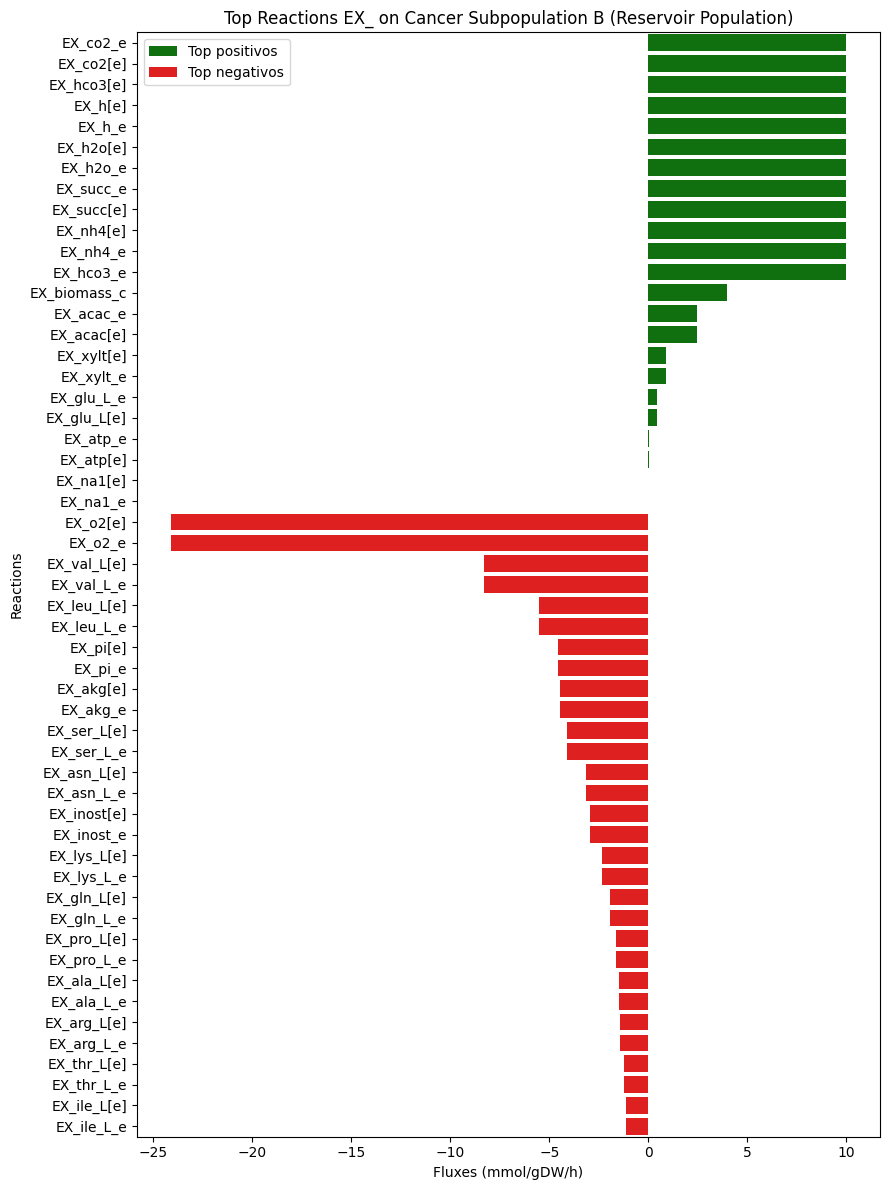

In [79]:
plt.figure(figsize=(9,12))

sns.barplot(x="flux", y="reaction", data=top_positive, color="green", label="Top positivos")

sns.barplot(x="flux", y="reaction", data=top_negative, color="red", label="Top negativos")

plt.xlabel("Fluxes (mmol/gDW/h)")
plt.ylabel("Reactions")
plt.title("Top Reactions EX_ on Cancer Subpopulation B (Reservoir Population)")
plt.legend()
plt.tight_layout()
plt.show()

#### **3.2.3. Subpoblación C (Proliferativa)** 

In [83]:
cancer_C_exchanges = sol_TyF.fluxes.loc["CanC", sol_TyF.fluxes.columns.str.startswith("EX_")]
cancer_C_exchanges_vertical = cancer_C_exchanges.reset_index()
cancer_C_exchanges_vertical.columns = ["reaction", "flux"]
cancer_C_exchanges_vertical["flux"] = cancer_C_exchanges_vertical["flux"].fillna(0) #NaN 0
cancer_C_exchanges_nonzero = cancer_C_exchanges_vertical[cancer_C_exchanges_vertical["flux"] != 0] #borramos los valores de reacción igual a 0

In [84]:
# Flujos positivos y negativos
top_positive = cancer_C_exchanges_nonzero[cancer_C_exchanges_nonzero["flux"] > 0].nlargest(30, "flux")
top_negative = cancer_C_exchanges_nonzero[cancer_C_exchanges_nonzero["flux"] < 0].nsmallest(30, "flux")

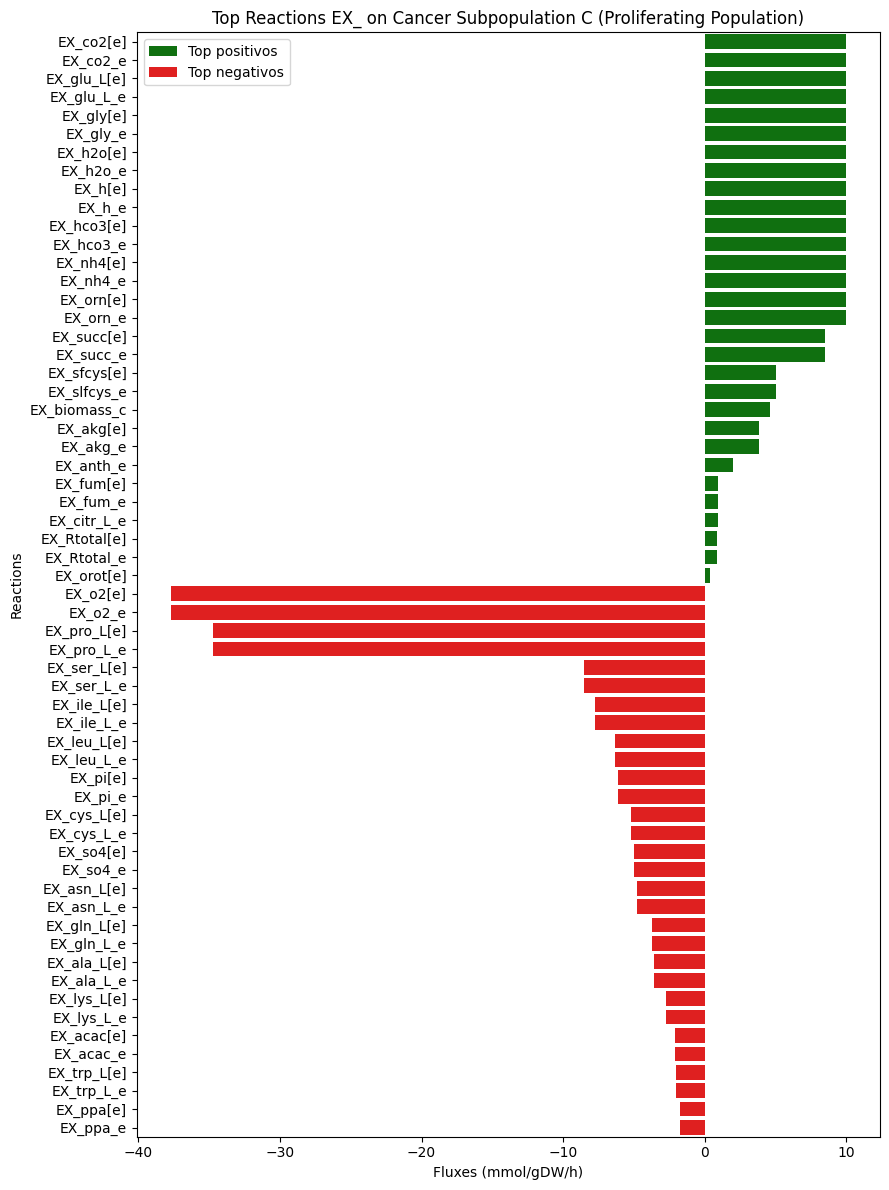

In [85]:
plt.figure(figsize=(9,12))

sns.barplot(x="flux", y="reaction", data=top_positive, color="green", label="Top positivos")

sns.barplot(x="flux", y="reaction", data=top_negative, color="red", label="Top negativos")

plt.xlabel("Fluxes (mmol/gDW/h)")
plt.ylabel("Reactions")
plt.title("Top Reactions EX_ on Cancer Subpopulation C (Proliferating Population)")
plt.legend()
plt.tight_layout()
plt.show()

### **3.3. Bacteria - Fusobacterium nucleatum**

#### **3.3.1. Fusobacterium nucleatum A**

In [87]:
fuso_A_exchanges = sol_TyF.fluxes.loc["FusoA", sol_TyF.fluxes.columns.str.startswith("EX_")]
fuso_A_exchanges_vertical = fuso_A_exchanges.reset_index()
fuso_A_exchanges_vertical.columns = ["reaction", "flux"]
fuso_A_exchanges_vertical["flux"] = fuso_A_exchanges_vertical["flux"].fillna(0) #NaN 0
fuso_A_exchanges_nonzero = fuso_A_exchanges_vertical[fuso_A_exchanges_vertical["flux"] != 0] #borramos los valores de reacción igual a 0

In [88]:
# Flujos positivos y negativos
top_positive = fuso_A_exchanges_nonzero[fuso_A_exchanges_nonzero["flux"] > 0].nlargest(30, "flux")
top_negative = fuso_A_exchanges_nonzero[fuso_A_exchanges_nonzero["flux"] < 0].nsmallest(30, "flux")

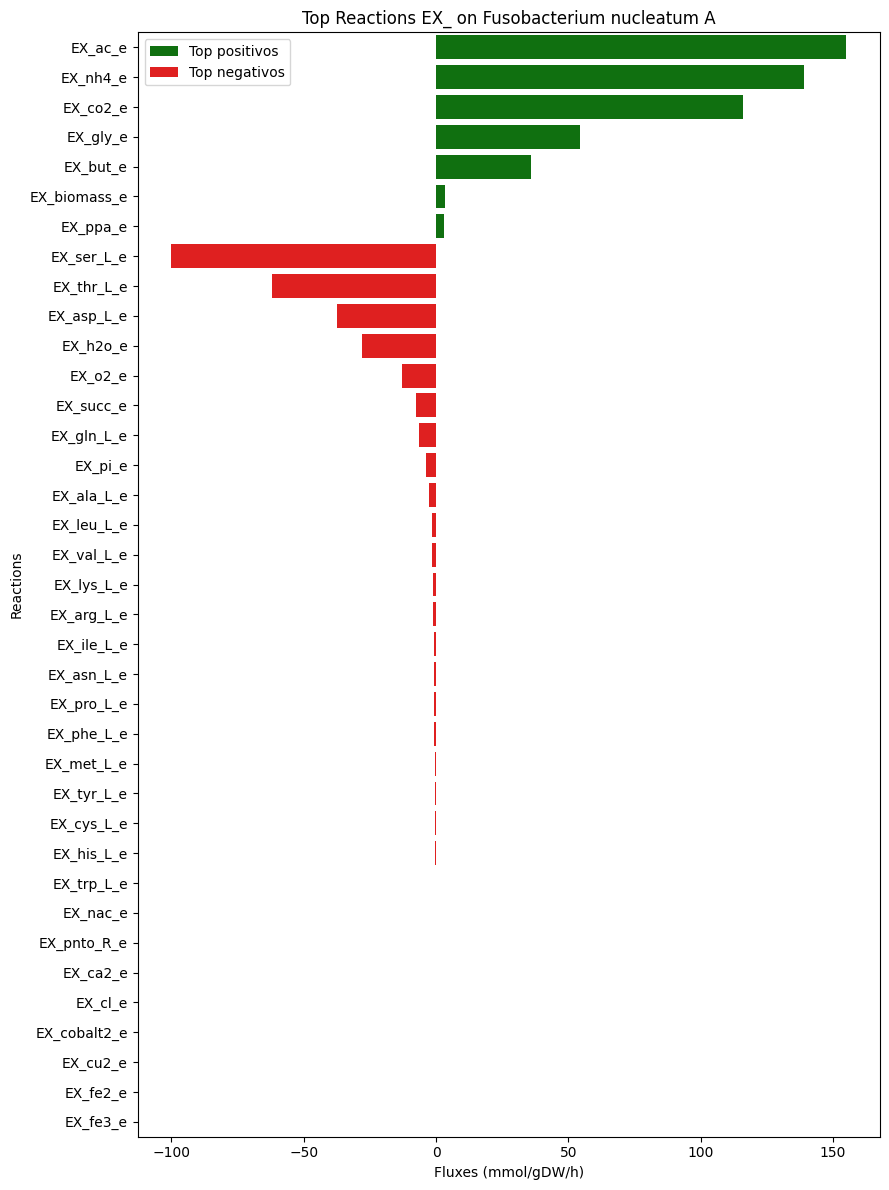

In [89]:
plt.figure(figsize=(9,12))

sns.barplot(x="flux", y="reaction", data=top_positive, color="green", label="Top positivos")

sns.barplot(x="flux", y="reaction", data=top_negative, color="red", label="Top negativos")

plt.xlabel("Fluxes (mmol/gDW/h)")
plt.ylabel("Reactions")
plt.title("Top Reactions EX_ on Fusobacterium nucleatum A")
plt.legend()
plt.tight_layout()
plt.show()

#### **3.3.1. Fusobacterium nucleatum B**

In [90]:
fuso_B_exchanges = sol_TyF.fluxes.loc["FusoB", sol_TyF.fluxes.columns.str.startswith("EX_")]
fuso_B_exchanges_vertical = fuso_B_exchanges.reset_index()
fuso_B_exchanges_vertical.columns = ["reaction", "flux"]
fuso_B_exchanges_vertical["flux"] = fuso_B_exchanges_vertical["flux"].fillna(0) #NaN 0
fuso_B_exchanges_nonzero = fuso_B_exchanges_vertical[fuso_B_exchanges_vertical["flux"] != 0] #borramos los valores de reacción igual a 0

In [91]:
# Flujos positivos y negativos
top_positive = fuso_B_exchanges_nonzero[fuso_B_exchanges_nonzero["flux"] > 0].nlargest(30, "flux")
top_negative = fuso_B_exchanges_nonzero[fuso_B_exchanges_nonzero["flux"] < 0].nsmallest(30, "flux")

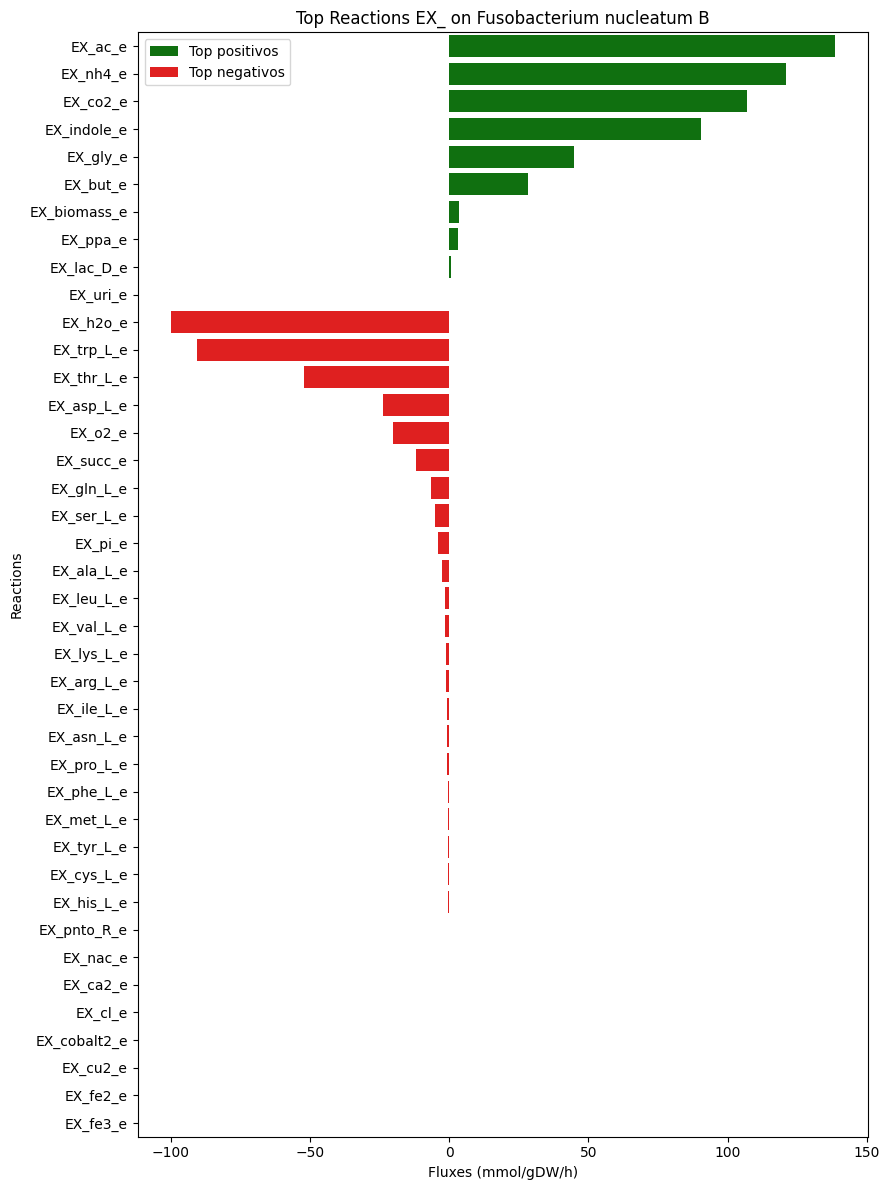

In [92]:
plt.figure(figsize=(9,12))

sns.barplot(x="flux", y="reaction", data=top_positive, color="green", label="Top positivos")

sns.barplot(x="flux", y="reaction", data=top_negative, color="red", label="Top negativos")

plt.xlabel("Fluxes (mmol/gDW/h)")
plt.ylabel("Reactions")
plt.title("Top Reactions EX_ on Fusobacterium nucleatum B")
plt.legend()
plt.tight_layout()
plt.show()

#### **3.3.1. Fusobacterium nucleatum C**

In [93]:
fuso_C_exchanges = sol_TyF.fluxes.loc["FusoC", sol_TyF.fluxes.columns.str.startswith("EX_")]
fuso_C_exchanges_vertical = fuso_C_exchanges.reset_index()
fuso_C_exchanges_vertical.columns = ["reaction", "flux"]
fuso_C_exchanges_vertical["flux"] = fuso_C_exchanges_vertical["flux"].fillna(0) #NaN 0
fuso_C_exchanges_nonzero = fuso_C_exchanges_vertical[fuso_C_exchanges_vertical["flux"] != 0] #borramos los valores de reacción igual a 0

In [94]:
# Flujos positivos y negativos
top_positive = fuso_C_exchanges_nonzero[fuso_C_exchanges_nonzero["flux"] > 0].nlargest(30, "flux")
top_negative = fuso_C_exchanges_nonzero[fuso_C_exchanges_nonzero["flux"] < 0].nsmallest(30, "flux")

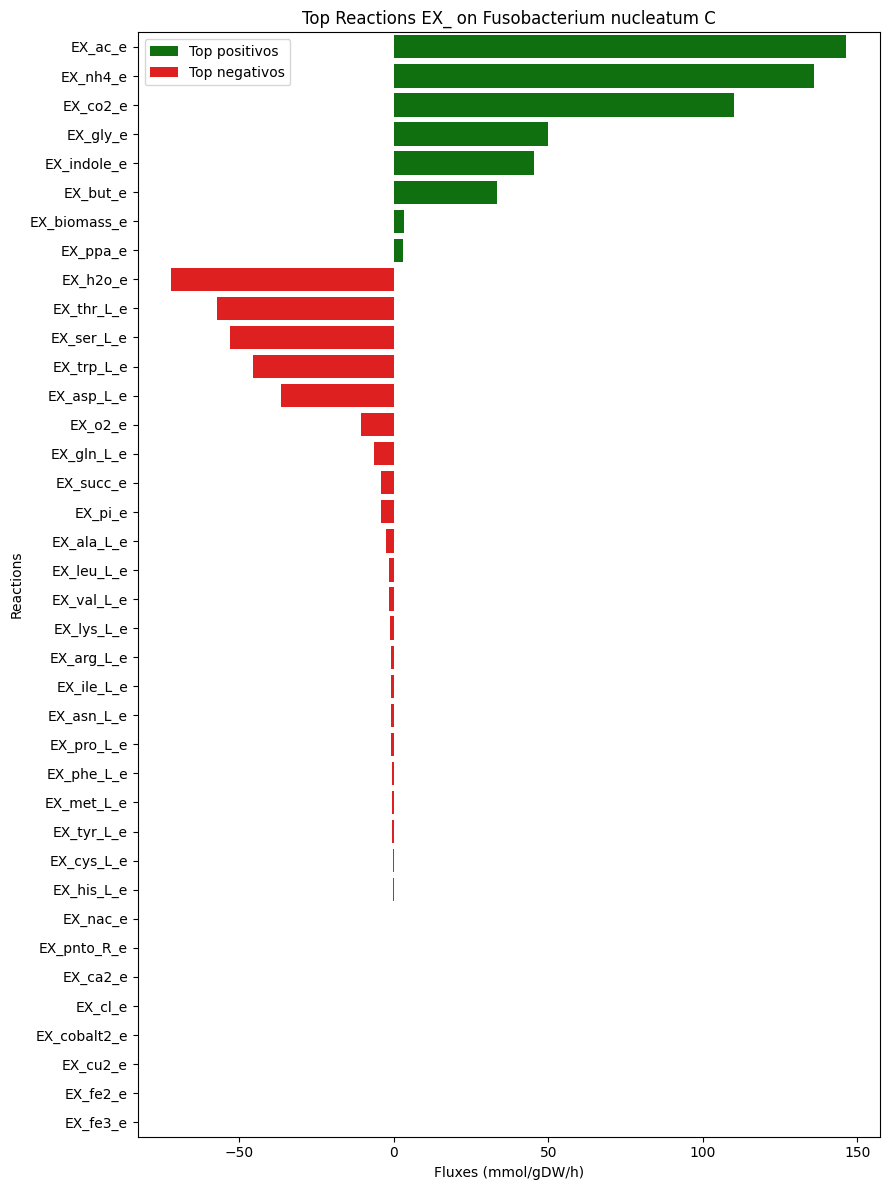

In [95]:
plt.figure(figsize=(9,12))

sns.barplot(x="flux", y="reaction", data=top_positive, color="green", label="Top positivos")

sns.barplot(x="flux", y="reaction", data=top_negative, color="red", label="Top negativos")

plt.xlabel("Fluxes (mmol/gDW/h)")
plt.ylabel("Reactions")
plt.title("Top Reactions EX_ on Fusobacterium nucleatum C")
plt.legend()
plt.tight_layout()
plt.show()